# LSTM ResOps-ES: results
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 06-05-2024*<br>

**Introduction:**<br>
This _notebook_ trains and tests an LSTM model to reproduce reservoir storage.

**Por hacer**:

In [1]:
import sys
sys.path.append('../..')
# import pickle
import pandas as pd
from pathlib import Path
import torch
from tqdm.notebook import tqdm

from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

from model_utils import *

In [6]:
import matplotlib.patches as mpatches

### Configuración

In [30]:
# cargar archivo de configuración
config_file = Path('config_O_lstm32_fc16_do03.yml')
cfg = Config(config_file)

target = cfg.target_variables[0]

print(cfg.experiment_name)
print('epochs:', cfg.epochs, sep='\t\t')
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

O_lstm32_fc16_do03
epochs:		30
hidden size:	32
batch size:	128
dropout:	0.5
clip gradients:	1


### Simulación

In [31]:
# simulación del entrenamiento y evaluación de todas las épocas?
run_all = True

# find the directory of the last run
root_run_dir = cfg.run_dir if cfg.run_dir else Path('./runs/')
run_dir = max([x for x in root_run_dir.iterdir() if x.is_dir() & x.stem.startswith(cfg.experiment_name)])

print(run_dir)

runs/O_lstm32_fc16_do03_0305_171326


In [32]:
for period in ['train']:#, 'test']:
    if run_all:
        for epoch in np.arange(1, cfg.epochs + 1):
            if torch.cuda.is_available(): # con GPU
                eval_run(run_dir=run_dir, period=period, epoch=epoch, gpu=0)
            else: # con CPU
                eval_run(run_dir=run_dir, period=period, epoch=epoch, gpu=-1)
    else:
        if torch.cuda.is_available(): # con GPU
            eval_run(run_dir=run_dir, period=period, epoch=best_epoch, gpu=0)
        else: # con CPU
            eval_run(run_dir=run_dir, period=period, epoch=best_epoch, gpu=-1)

# Evaluation: 100% 20/20 [00:09<00:00,  2.07it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.36it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.26it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.36it/s]
# Evaluation: 100% 20/20 [00:09<00:00,  2.17it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.32it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.37it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.38it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.43it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.32it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.41it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.36it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.35it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.38it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.26it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.36it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.35it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.40it/s]
# Evaluation: 100% 20/20 [00:08<00:00,  2.34it/s]
# Evaluation: 100% 20/20 [00:09<00:00,  2.18it/s]


## Results

### Evolution of training and validation

In [33]:
# extraer el rendimiento de cada época y muestra
metrics = {period: pd.DataFrame(columns=range(1, cfg.epochs + 1)) for period in ['train', 'validation']} # ['train', 'validation', 'test']}
for period, df in tqdm(metrics.items(), desc='period'):
    for epoch in df.columns:
        try:
            _, df[epoch] = get_results(run_dir, period, epoch=epoch)
        except:
            continue

period:   0%|          | 0/2 [00:00<?, ?it/s]

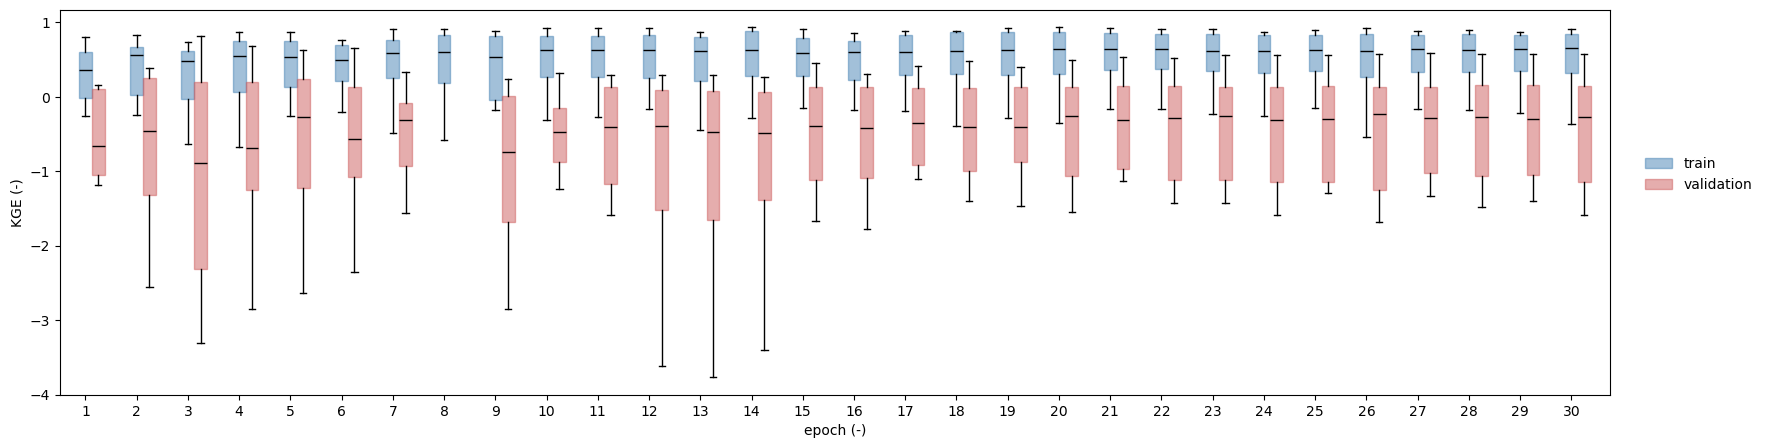

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'khaki']
patches = []
for i, ((period, df), c) in enumerate(zip(metrics.items(), colors)):
    bp = ax.boxplot(df, positions=df.columns + i * .25, widths=0.25,
                    patch_artist=True,
                    boxprops={'color': c, 'alpha': .5},
                    # whiskerprops={},
                    showfliers=False,
                    medianprops={'color': 'k'})
    for box in bp['boxes']:
        box.set_facecolor(c)
    patches.append(mpatches.Patch(color=c, alpha=.5, label=period))

# ax.set_ylim(-1, 1);
xticks = np.linspace(1, cfg.epochs, num=cfg.epochs).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set(xlabel='epoch (-)',
       ylabel=f'{cfg.metrics[0]} (-)');

ax.legend(handles=patches, frameon=False, bbox_to_anchor=[1, .35, .1, .3]);

# plt.savefig(run_dir / 'evolucion_KGE.jpg', dpi=300, bbox_inches='tight')

### Best epoch

In [35]:
# mejor época de cada muestra y el rendimiento de cada muestra en esa época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}'.format(epoch,
                                                                        metrics['train'][epoch].median(),
                                                                        metrics['validation'][epoch].median()))
epoch = best_epoch['validation']

epoch 30:	KGEtrain = 0.654   KGEval = -0.266
epoch 26:	KGEtrain = 0.621   KGEval = -0.232


In [36]:
# rendimiento y series simuladas de la mejor época
series = {}
rendimiento = pd.DataFrame()
for period in ['train', 'validation']:
    # importar resultados
    series_period, rend_period = get_results(run_dir, period, epoch=epoch)
    rend_period.columns = [period]
    series[period] = series_period
    rendimiento = pd.concat((rendimiento, rend_period), axis=1)

/home/casadje/neuralhydrology/models/ResOpsES/hydropower/../../model_utils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)#, sharex=True, sharey=True)


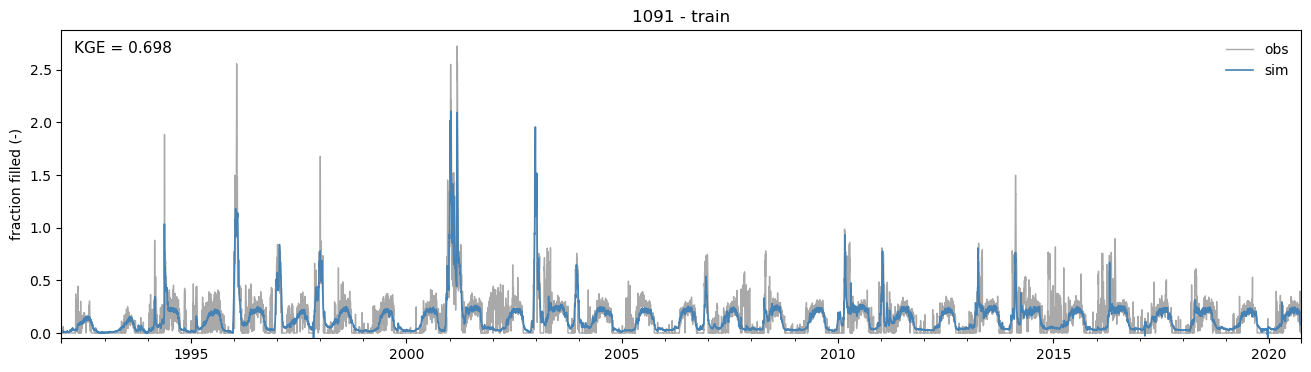

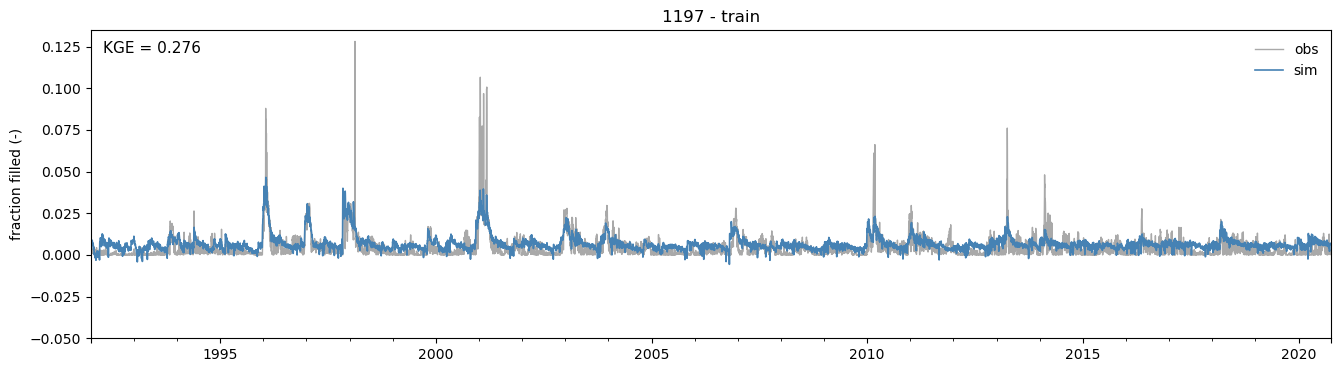

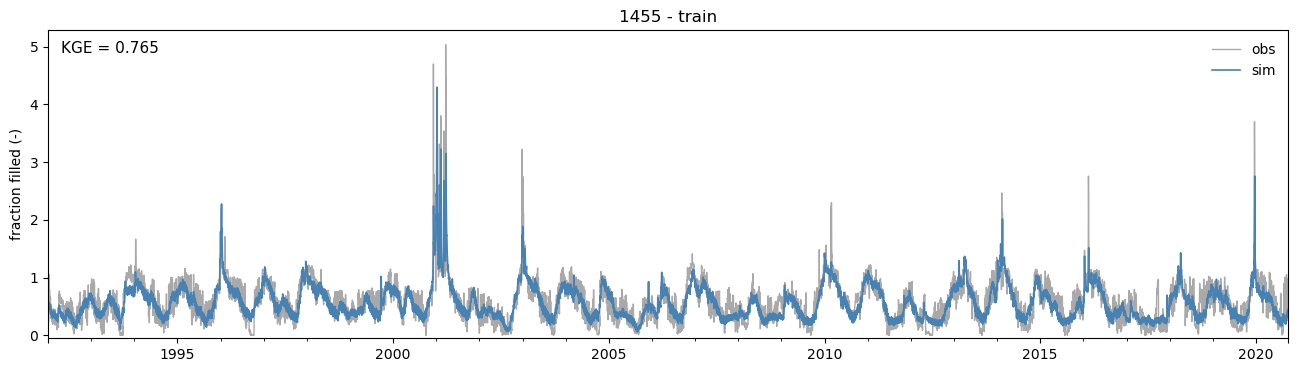

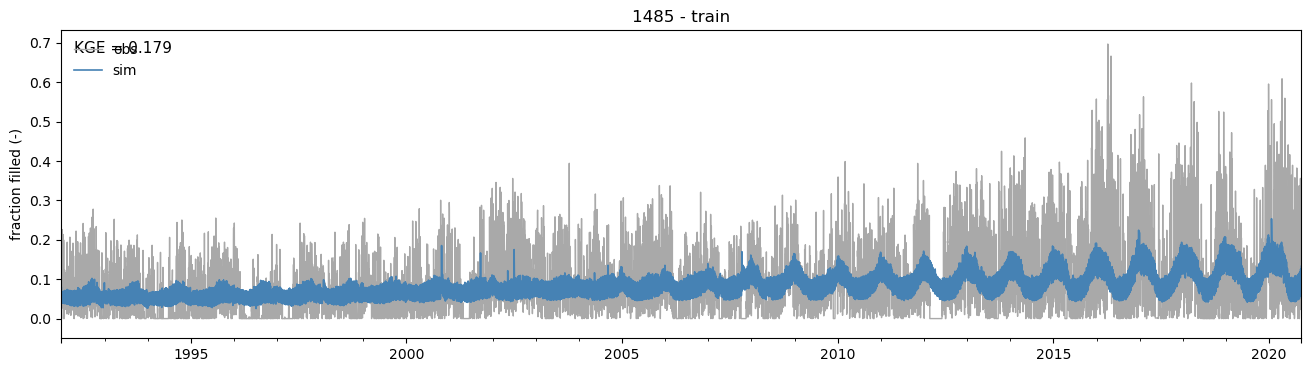

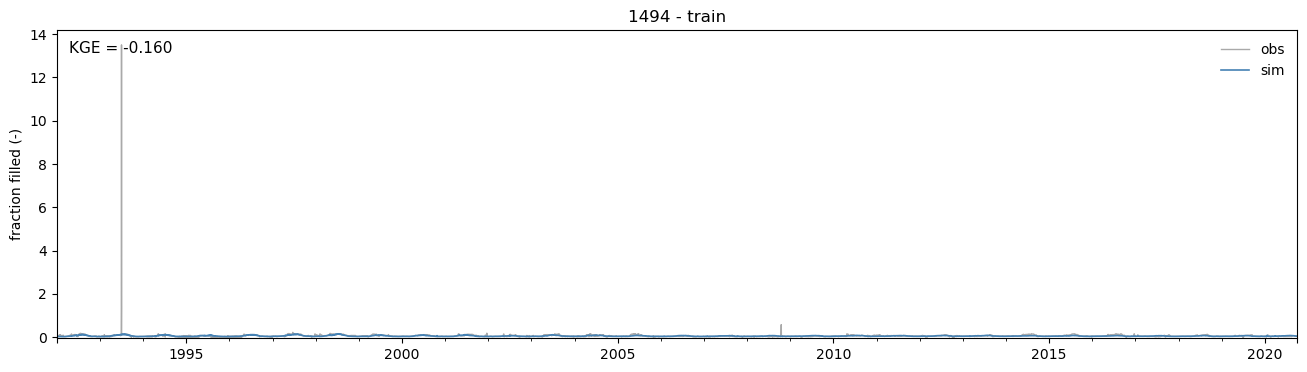

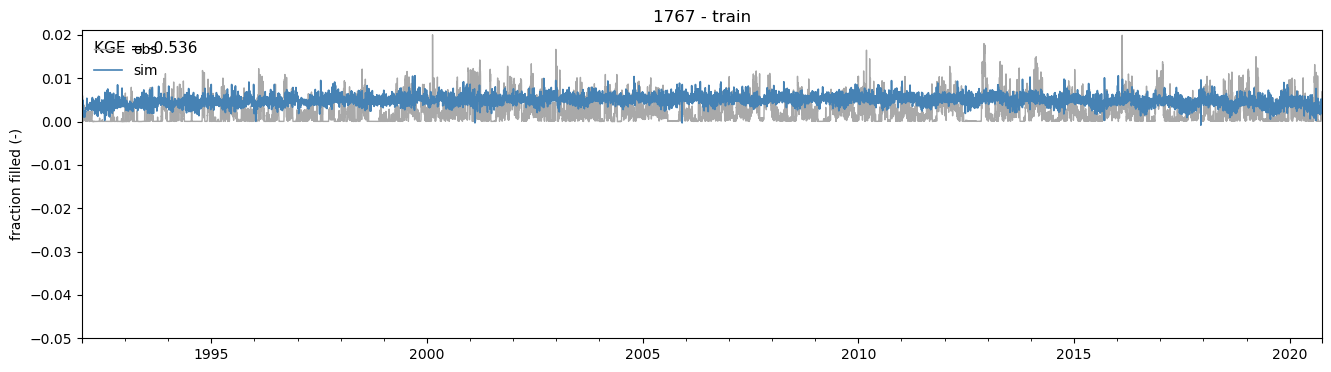

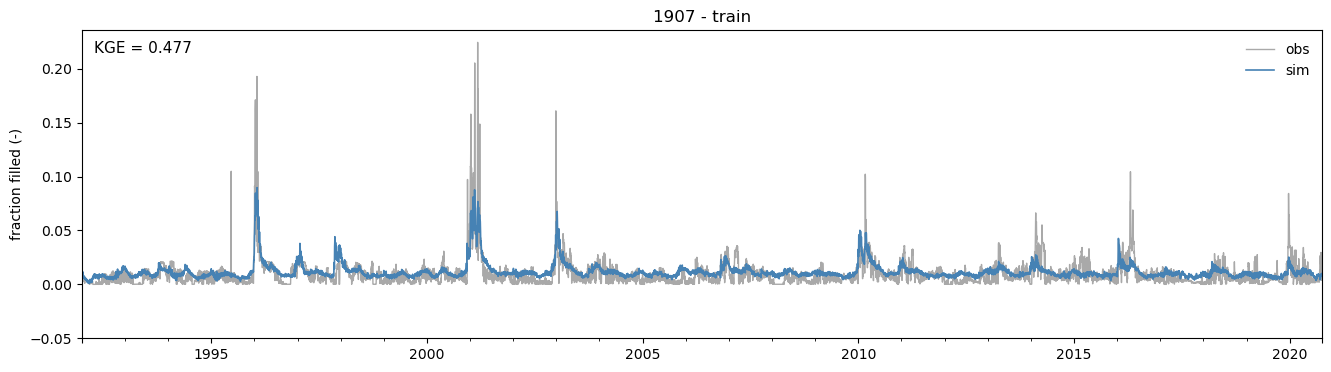

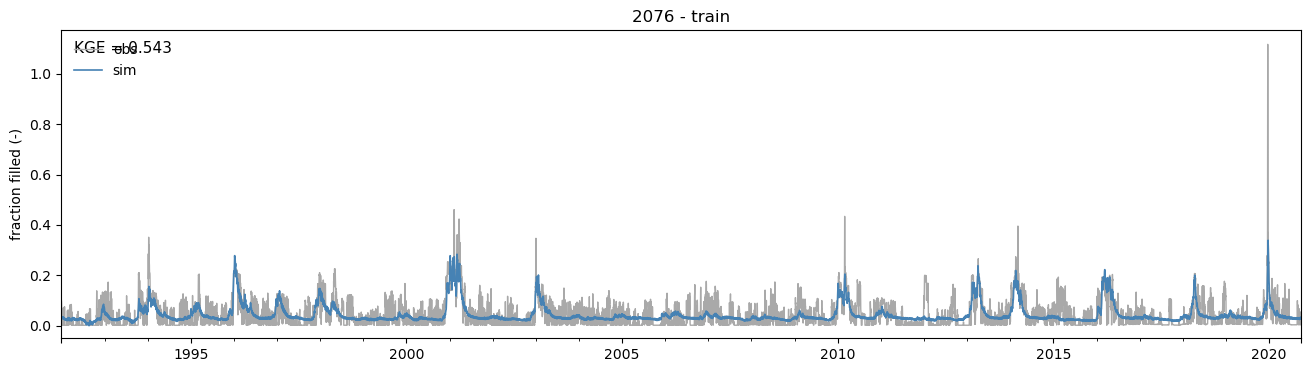

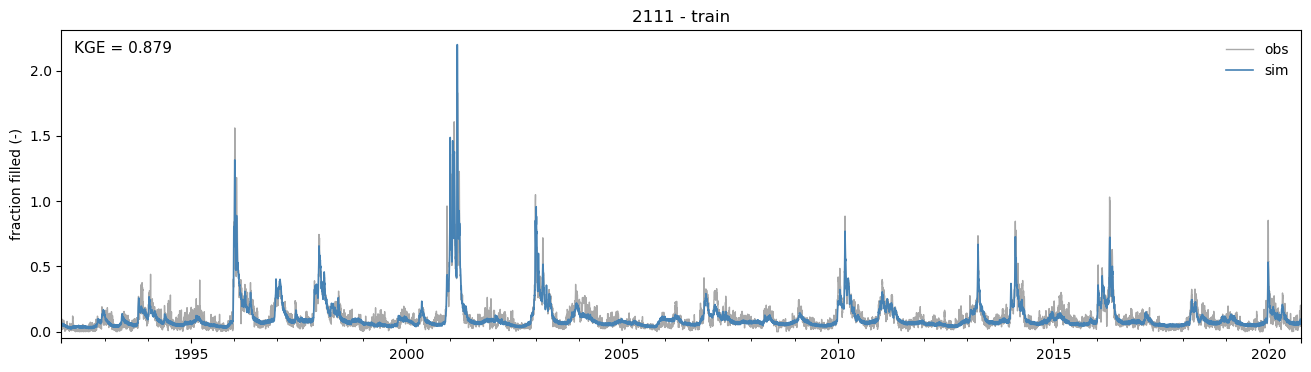

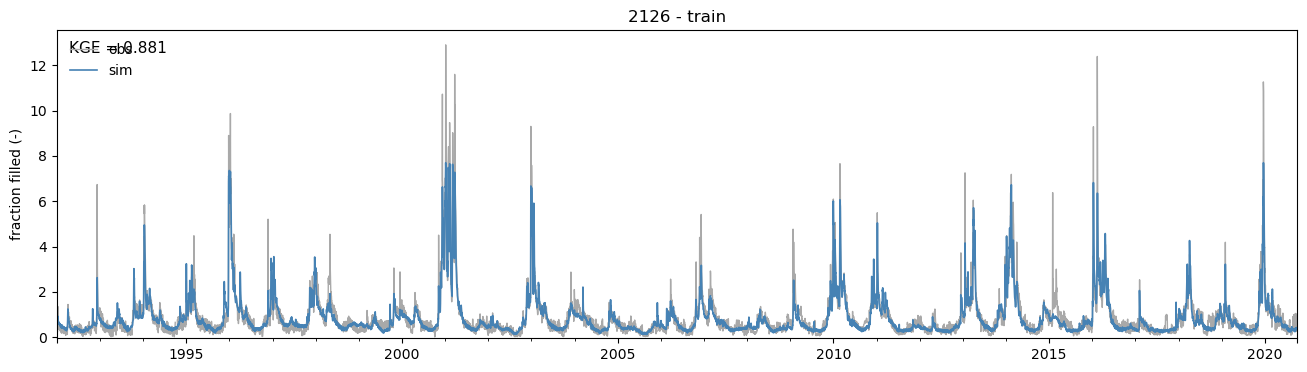

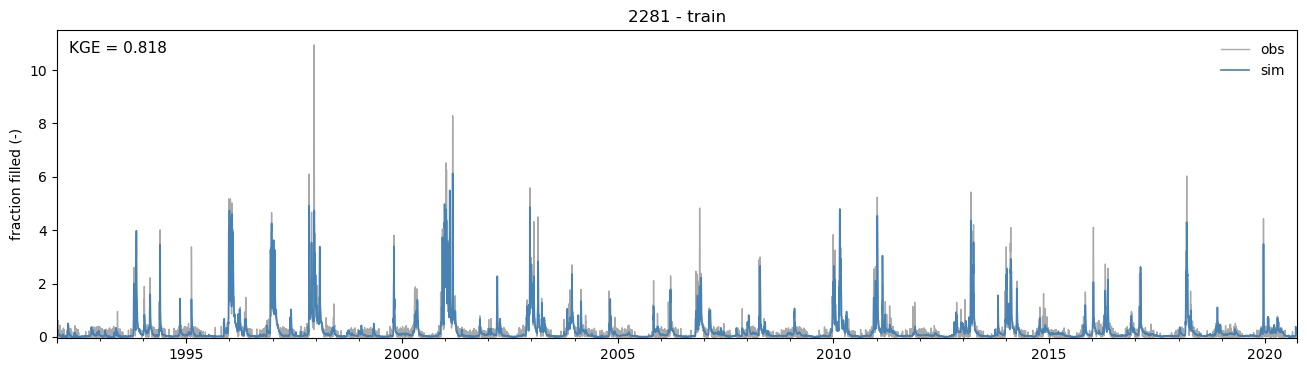

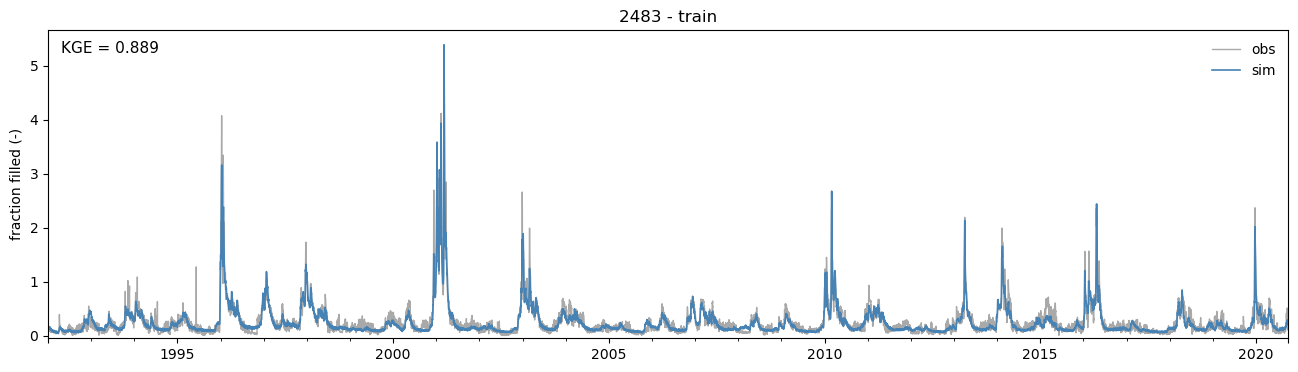

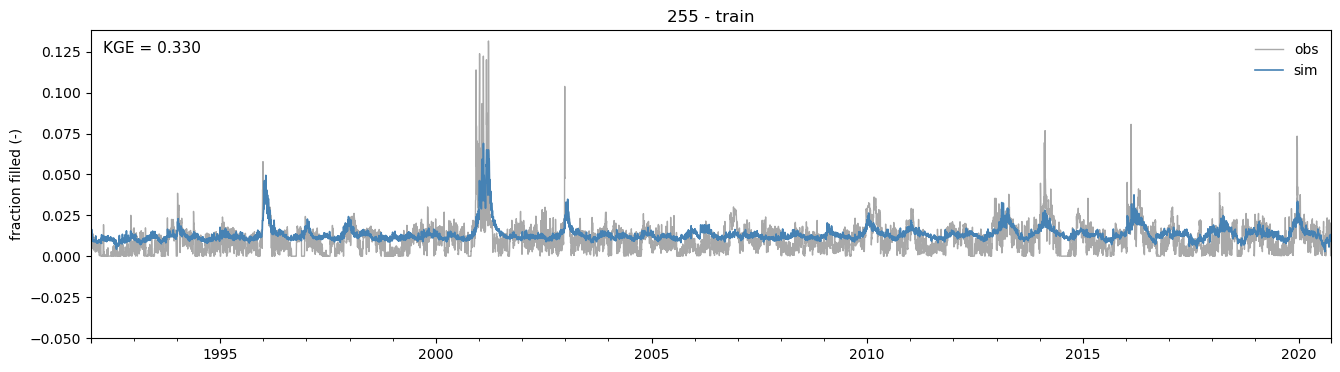

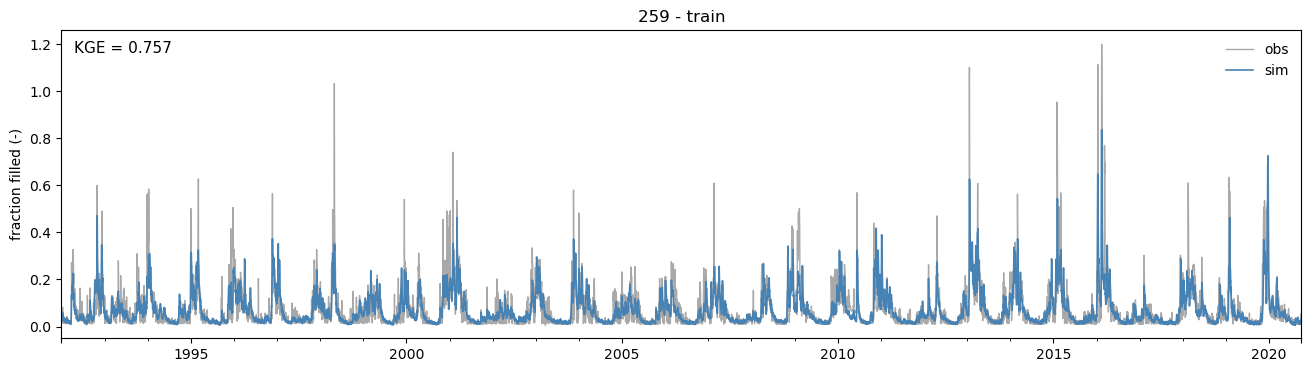

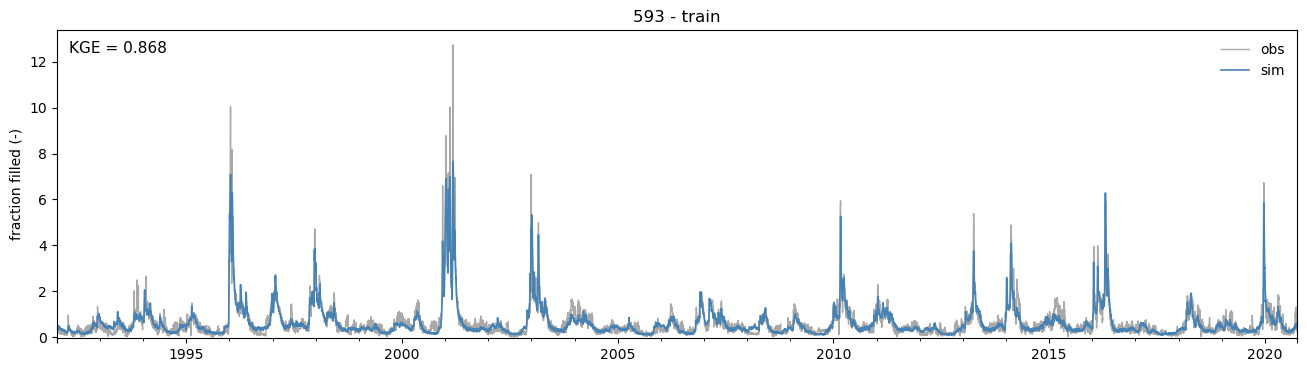

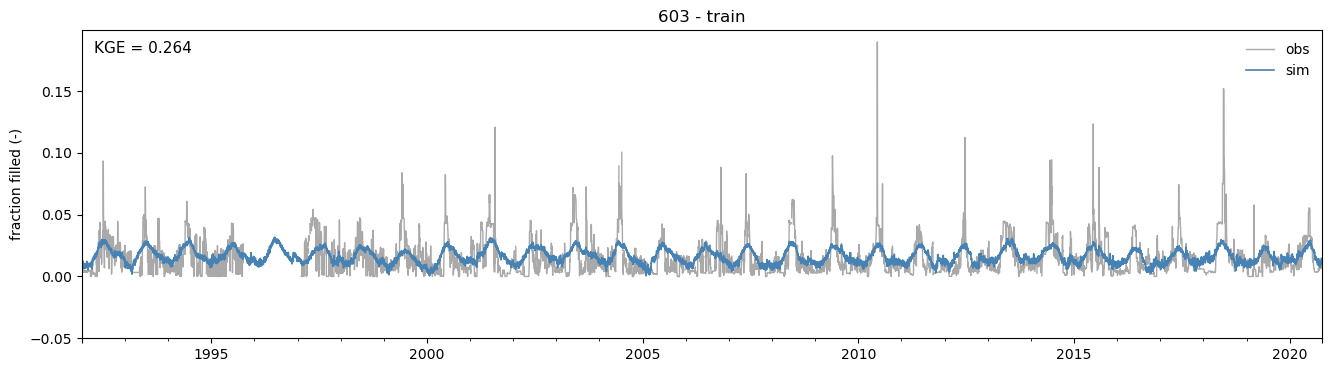

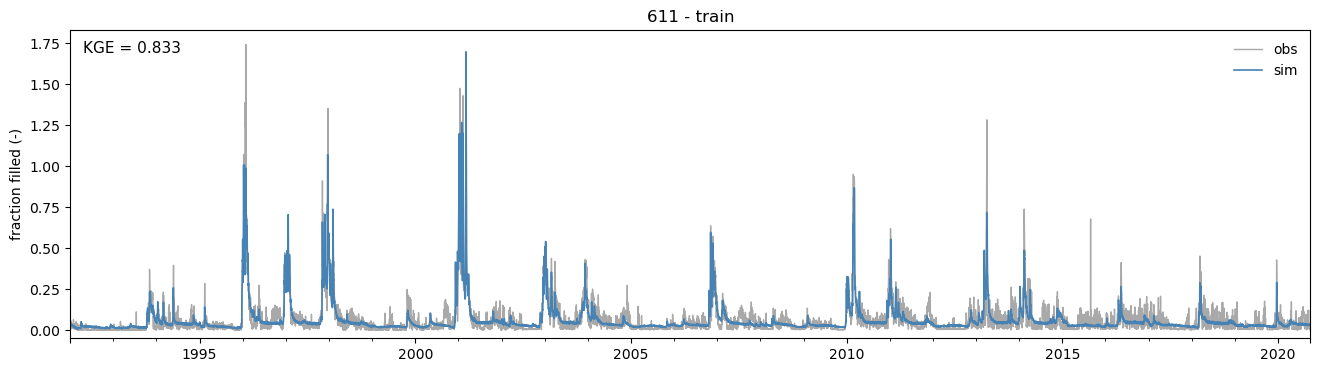

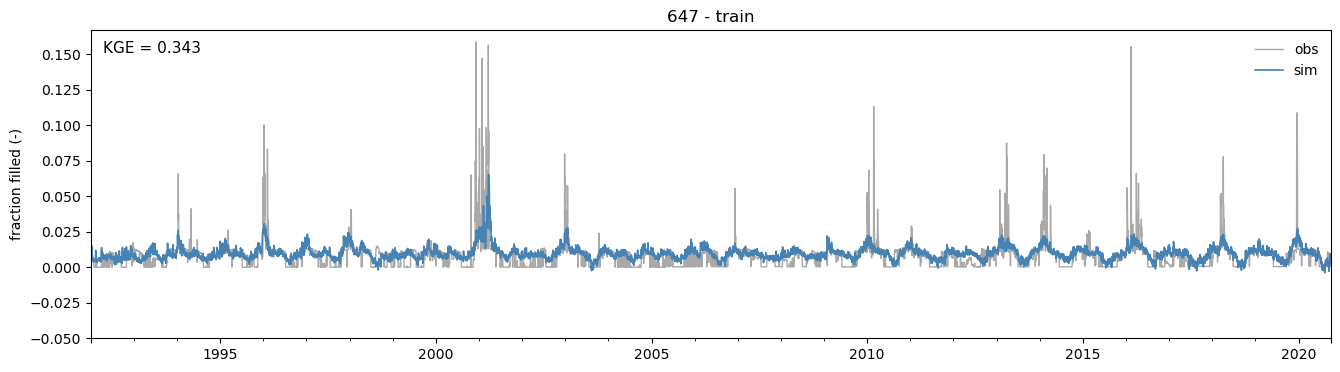

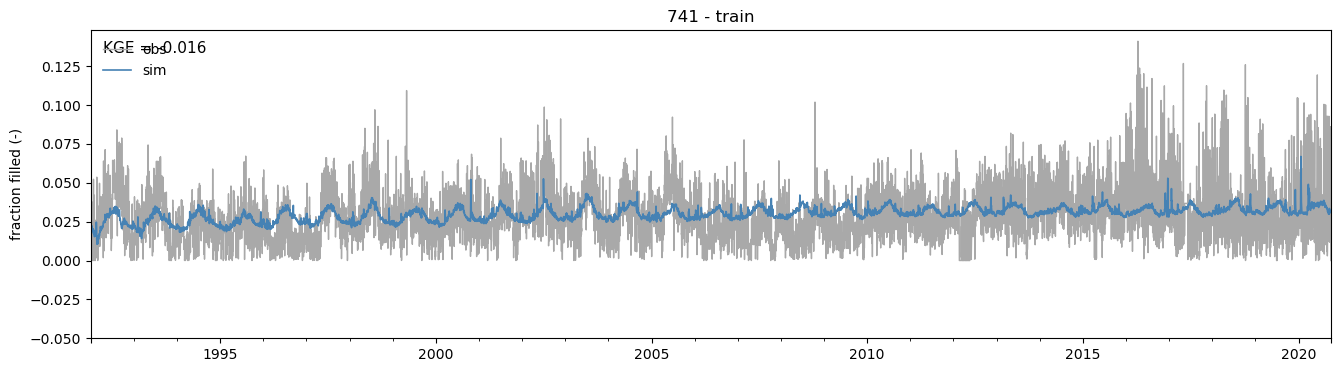

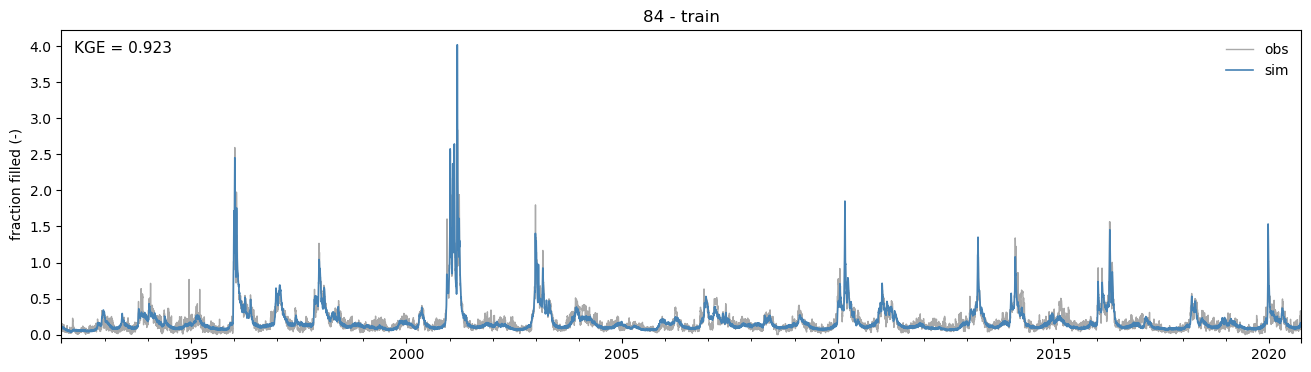

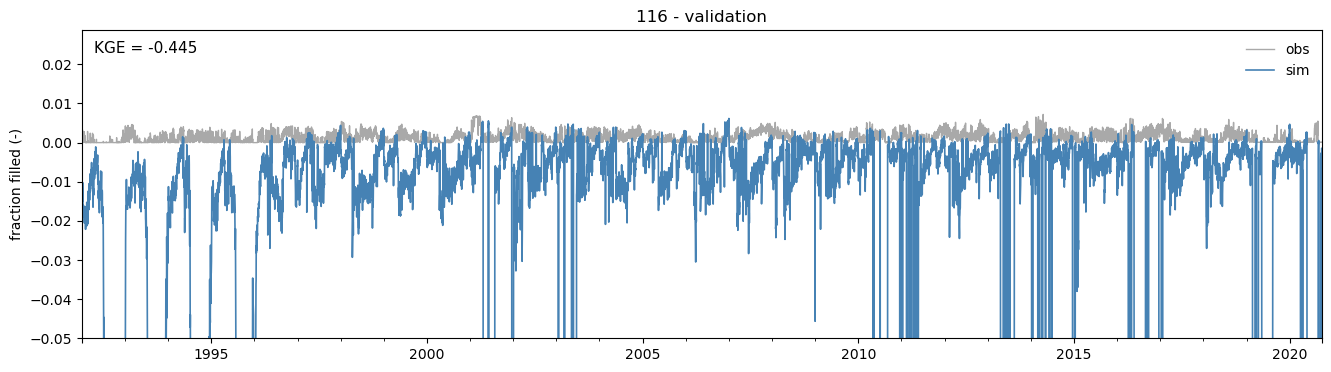

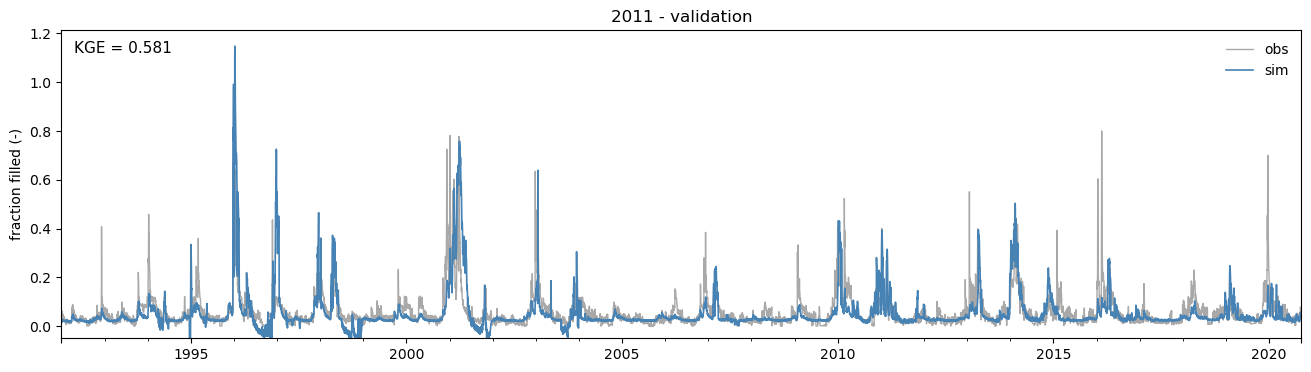

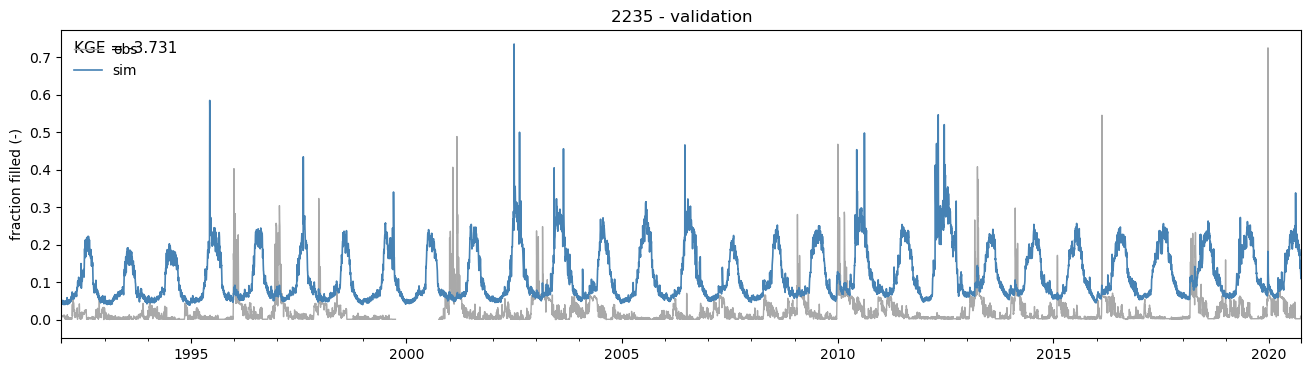

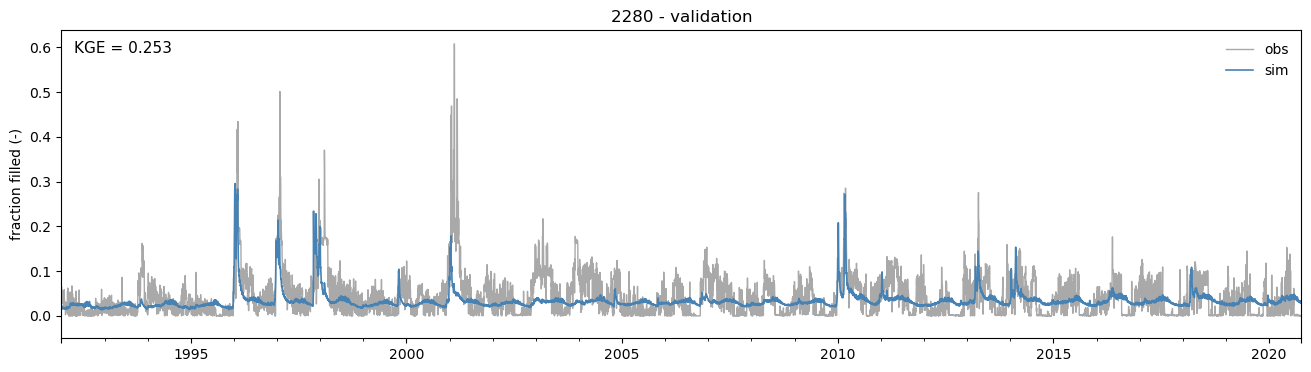

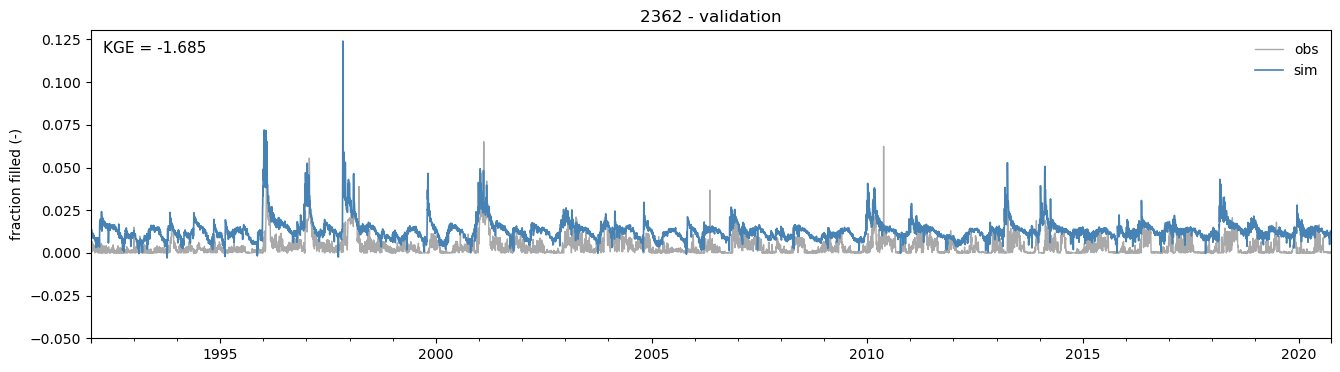

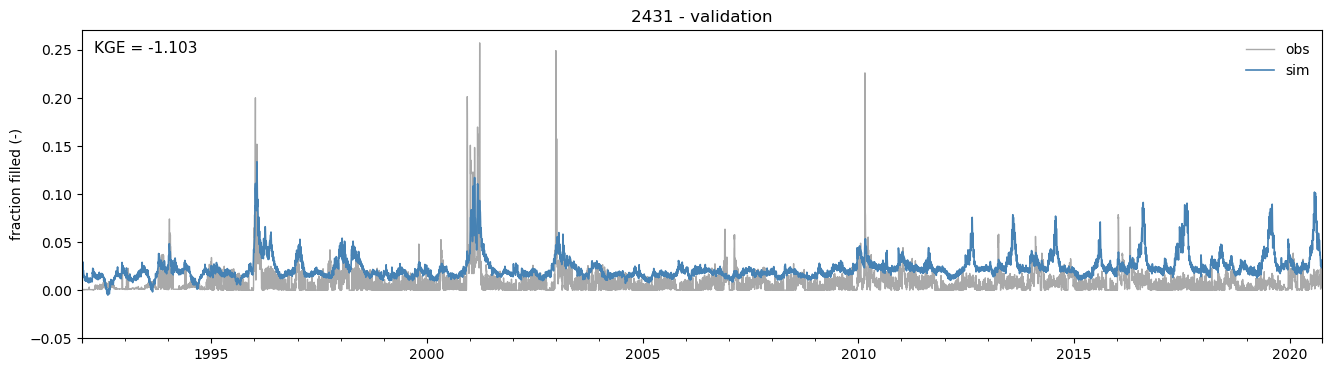

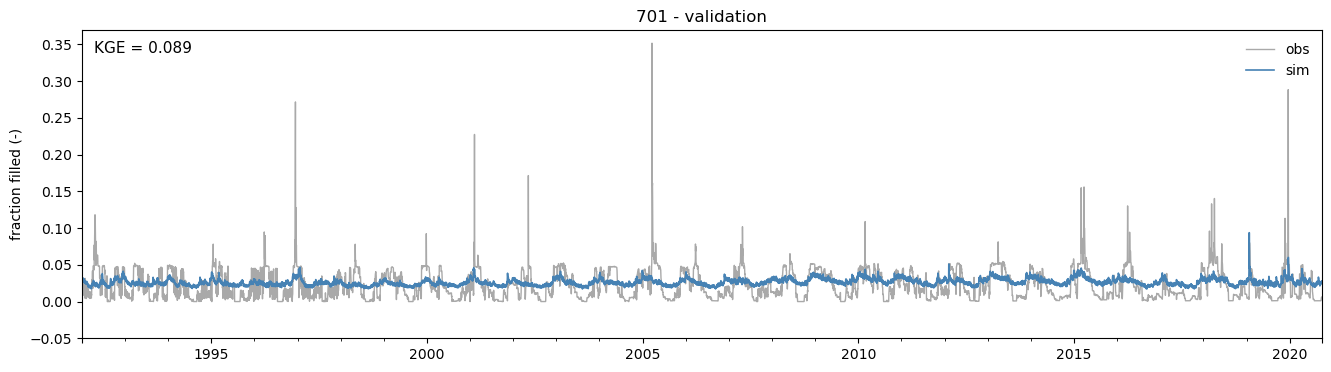

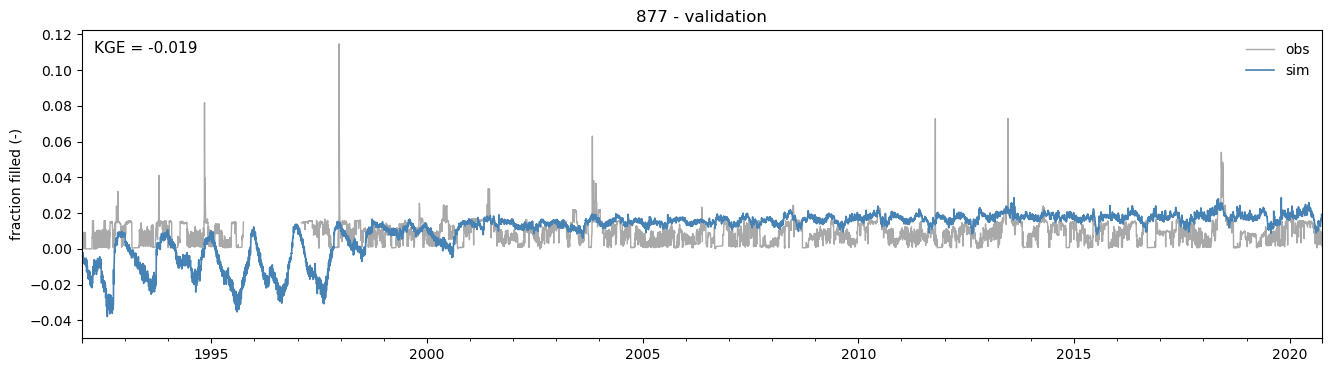

In [38]:
# hidrogramas
# if hidrogramas:
for period, dct in series.items():
    path = run_dir / 'plots' / period
    path.mkdir(parents=True, exist_ok=True)
    plot_results(dct, period, target=cfg.target_variables[0], ylim=(-.05, None), ylabel='fraction filled (-)', save=None)#path)